#  Прогнозирование заказов такси

## Подготовка

Импорт необходимых библиотек, функций и моделей:

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna 
import lightgbm as lgbm

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit

### Загрузка данных

Импортируем датафрейм:

In [5]:
data = pd.read_csv('/Users/mihail/Downloads/data science/project of sprint 15/taxi.csv')
data

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


### Изучение данных

Датасет состоит из двух признаков: datetime	и num_orders. Количество объектов: 26496.

Проверим наличие дубликатов:

In [6]:
data.duplicated().sum()

0

Проверим наличие пропусков:

In [7]:
data.isna().sum()

datetime      0
num_orders    0
dtype: int64

Меняем индекс:

In [8]:
data.index = data['datetime']
data = data.drop('datetime', axis=1)
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Данные в датасете следуют с шагом в 10 минут.

In [9]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Максимальное и минимальные значения адекватны.

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0+ KB


Проверим хронологический порядок индекса:

In [11]:
data.index.is_monotonic_increasing

True

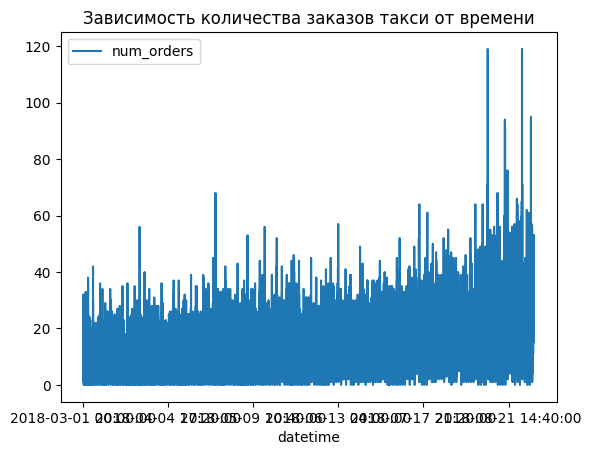

In [12]:
data.plot(title='Зависимость количества заказов такси от времени'); #график временного ряда

### Ресемплирование данных

Прогноз нужен на час вперед, поэтому выполняем ресемплирование по одному часу, предваорительно преобразовав тип индекса для корректной работы метода resample():

In [13]:
data.index = data.index.astype('datetime64[ns]')

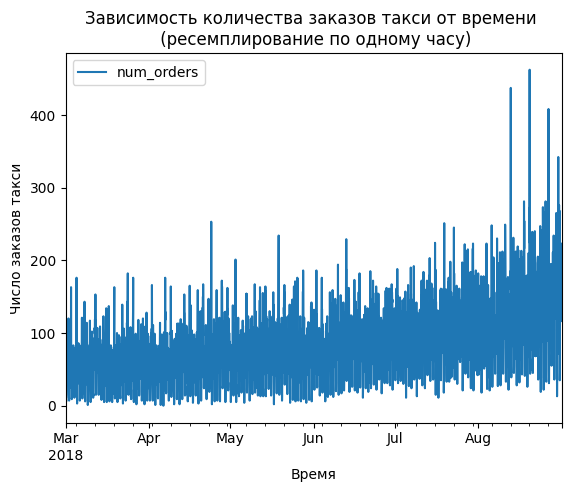

In [14]:
data = data.resample('1H').sum()
data.plot(title='Зависимость количества заказов такси от времени \n (ресемплирование по одному часу)',\
          ylabel='Число заказов такси', xlabel='Время'); 

### Промежуточные выводы

В ходе подготовки данных:
- загружен исходный датафрейм с 2 признаками и 26496 объектами;
- дубликаты и пропуски в датасете не обнаружены;
- аномалий не выявлено: максимальные и минимальные значения адекватны;
- индекс датасета заменен значениями признака datetime, который представлен в хронологическом порядке с шагом в 10 минут;
- для дальнейшего прогноза на один час вперед проведено ресемплирование ряда с периодом один час.

## Анализ

### Скользящее среднее и скольщее отклонение ряда

Построим скользящее среднее и скользящее отклонение:

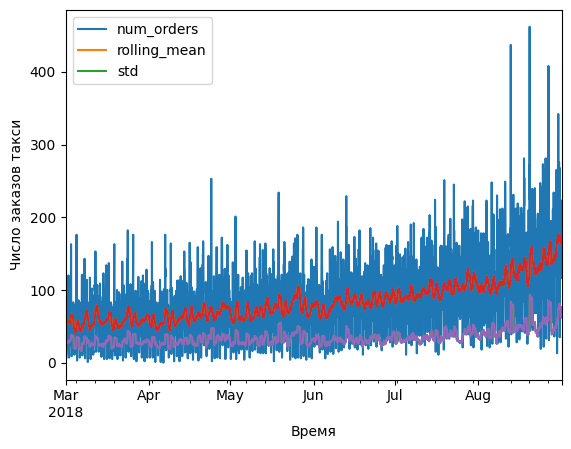

In [15]:
data['rolling_mean'] = data['num_orders'].rolling(24).mean()# усредним по дням
data['std'] = data['num_orders'].rolling(24).std()
data.plot()
data['rolling_mean'].plot(); 
data['std'].plot(ylabel='Число заказов такси', xlabel='Время');

Прослеживается тренд на возрастание числа заказов от весны к лету - все логично.

In [16]:
# средние значения скользящего среднего и скольщего отклонения
print(data['rolling_mean'].mean())
print(data['std'].mean())

84.27608316260718
35.32905271862886


Ряд нельзя назвать стационарным, поскольку среднее и отклонение меняются. Ряд является стационарным на врпменном отрезке с марта по май.

In [17]:
data=data.drop(['rolling_mean','std'], axis=1)

### Тренд, сезонная и случайная составляющие

Исследуем временной ряд на наличие тренда, сезонной и случайной составляющих с помощью функции seasonal_decompose(): 

In [18]:
decomposed = seasonal_decompose(data)

Строим графики:

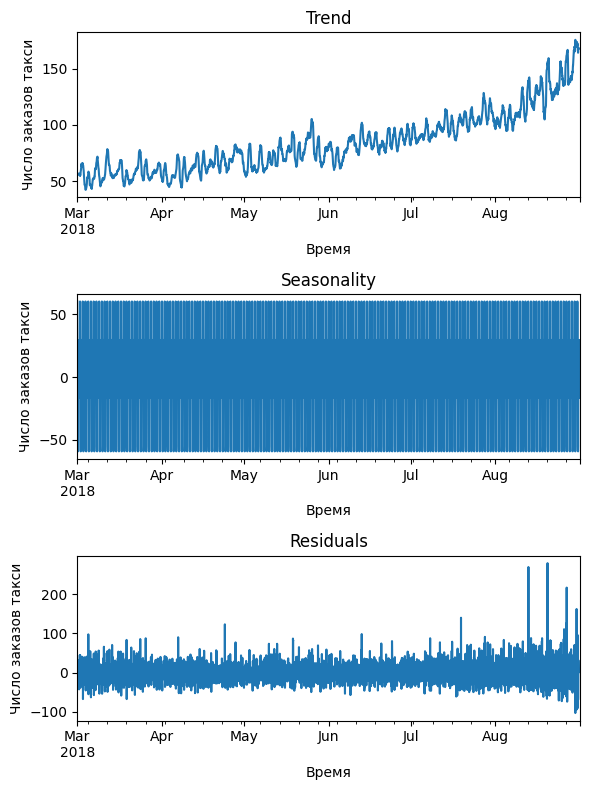

In [19]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), ylabel='Число заказов такси', xlabel='Время')
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), ylabel='Число заказов такси', xlabel='Время')
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), ylabel='Число заказов такси', xlabel='Время')
plt.title('Residuals')
plt.tight_layout()

Все логично. Тренд такой же, как и при использовании скользящего среднего. Случайная составляющая коррелирована со скользящим отклонением - в конце и середине августа видим несколько всплесков. 

График сезонности почти сплошной из-за большой частоты сезонной составляющей. Изменим масштаб:

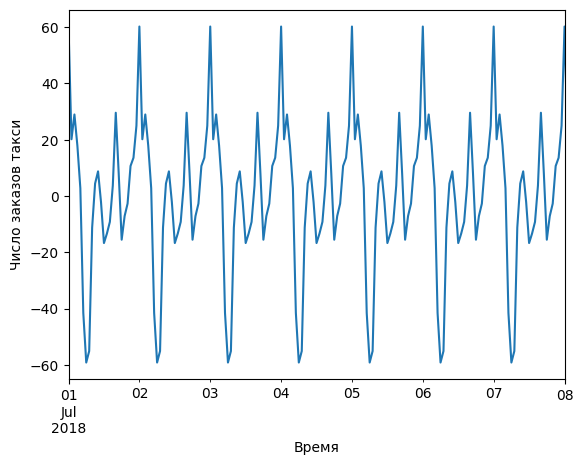

In [20]:
decomposed.seasonal.plot(
    xlim=['2018-07-01 00:00:00', '2018-07-08 00:00:00'], ylabel='Число заказов такси', xlabel='Время');

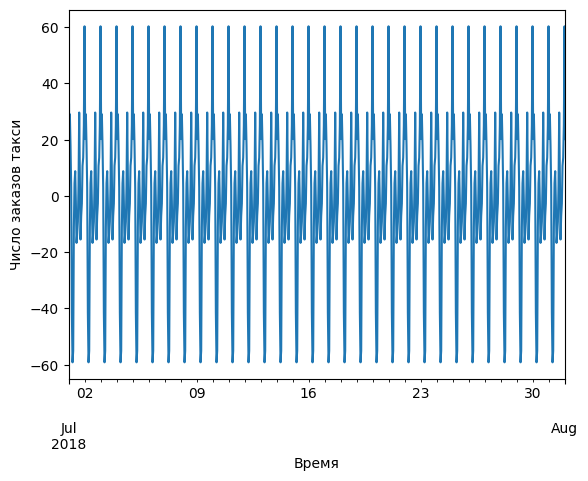

In [21]:
decomposed.seasonal.plot(
    xlim=['2018-07-01 00:00:00', '2018-08-01 00:00:00'], ylabel='Число заказов такси', xlabel='Время');

Сезонность соответствует периоду в одни сутки. Недельной, так и месячной сезонности не наблюдается. Годовую сезонность не оценим, поскольку поо условию есть данные только за весну и лето.

### Использование временной разности

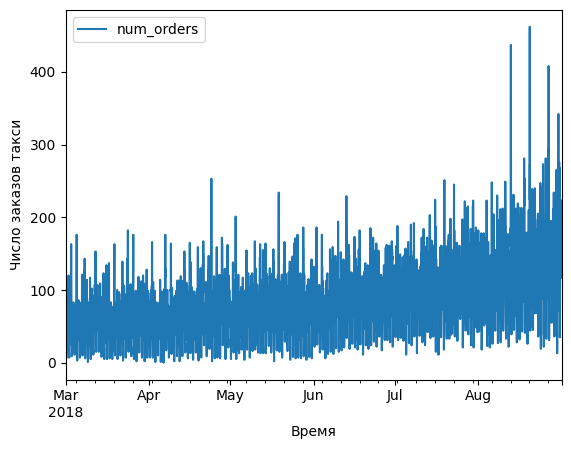

In [22]:
data = data.shift(fill_value=0)
data.plot(ylabel='Число заказов такси', xlabel='Время');

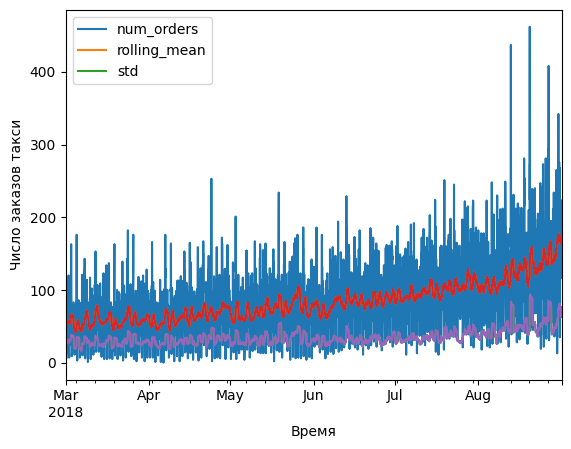

In [23]:
data['rolling_mean'] = data['num_orders'].rolling(24).mean()# усредним по дням
data['std'] = data['num_orders'].rolling(24).std()
data.plot()
data['rolling_mean'].plot(); 
data['std'].plot(ylabel='Число заказов такси', xlabel='Время');

In [24]:
print(data['rolling_mean'].mean())
print(data['std'].mean())

84.25036042188331
35.322090028463194


In [25]:
data=data.drop(['rolling_mean','std'], axis=1)

Использование разности временного ряда практически не повлияло на его стационарность.

### Промежуточные выводы

В ходе анализа временного ряда установлено:
- скользящее среднее и скольщее отклонение изменяются со временем, ряд можно условно назвать стационарным;
- присутствует тренд на возрастание числа машин в летний период, особенно с середины июля по август, что логично, поскольку это соответствует пиковому периоду отпусков;
- установлена сезонность по периоду, равному суткам (24 ч);
- использование разности временного ряда практически не сказалась на его стационарности: средние значения скользящего среднего и скольщего отклонения до разности 84.27608316260718 и 35.32905271862886, после разности - 84.25036042188331 и 35.322090028463194 соответственно.

## Обучение

Перед обучением моделей необходимо создать признаки и разделить данные на обучающую и тестовую выборки.

### Создание признаков

Добавим календарные признаки, отстающие значения и скольщее среднее, для чего напишем функцию:

In [26]:
data

,num_orders
datetime,
2018-03-01 00:00:00,0
2018-03-01 01:00:00,124
2018-03-01 02:00:00,85
2018-03-01 03:00:00,71
2018-03-01 04:00:00,66
...,...
2018-08-31 19:00:00,207
2018-08-31 20:00:00,136
2018-08-31 21:00:00,154


In [27]:
def make_features(data_feat, max_lag, rolling_mean_size):
    
    data_feat = data_feat.copy()
    data_feat['month'] = data_feat.index.month
    data_feat['day'] = data_feat.index.day
    data_feat['dayofweek'] = data_feat.index.dayofweek
    data_feat['hour'] = data_feat.index.hour
    
    for lag in range(1, max_lag + 1):
        data_feat['lag_{}'.format(lag)] = data_feat['num_orders'].shift(lag)

    # < напишите код здесь >
    data_feat['rolling_mean'] = data_feat['num_orders'].rolling(rolling_mean_size).mean().shift()
    return data_feat

data_feat = make_features(data, 9, 9)

In [28]:
data_feat

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,rolling_mean
datetime,,,,,,,,,,,,,,,
2018-03-01 00:00:00,0,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,124,3,1,3,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,85,3,1,3,2,124.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,71,3,1,3,3,85.0,124.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,66,3,1,3,4,71.0,85.0,124.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,207,8,31,4,19,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,169.555556
2018-08-31 20:00:00,136,8,31,4,20,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,170.000000
2018-08-31 21:00:00,154,8,31,4,21,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,163.888889


Год в календарных признаках не имеет смысла поскольку данные прдставлены за несколько месяцев конкретного года. Также, поскольку ресемплинг проведен по часу, то минуты и секунды не важны.

### Разделение данных на обучающую и тестовую выборки

Сначала разделим датасет на таргет и нецелевые признаки:

In [29]:
features = data_feat.drop('num_orders', axis=1)
target = data_feat['num_orders']

Разбиваем признаки и таргет на обучающую и тестовую выборки в соотношении 9:1

In [30]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, shuffle=False, test_size=0.1)

In [31]:
features_train.shape

(3974, 14)

In [32]:
target_train.shape

(3974,)

In [33]:
features_test.shape

(442, 14)

In [34]:
target_test.shape

(442,)

Массивы сформированы верно.

### Масштабирование признаков

Как показано ниже std признаков различны, поэтому масштабируем их. 

In [35]:
features_train.describe()

,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,rolling_mean
count,3974.000000,3974.000000,3974.000000,3974.000000,3973.000000,3972.000000,3971.000000,3970.000000,3969.000000,3968.000000,3967.000000,3966.000000,3965.000000,3965.000000
mean,5.227982,15.119779,3.025667,11.482386,78.257236,78.240685,78.221103,78.206297,78.203074,78.212954,78.216032,78.214826,78.198487,78.237635
std,1.578825,8.879751,2.001471,6.921338,38.690606,38.681408,38.666584,38.660196,38.664533,38.664396,38.668783,38.673585,38.664769,23.864778
min,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.888889
25%,4.000000,7.000000,1.000000,5.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,60.666667
50%,5.000000,15.000000,3.000000,11.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.888889
75%,7.000000,23.000000,5.000000,17.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,94.666667
max,8.000000,31.000000,6.000000,23.000000,437.000000,437.000000,437.000000,437.000000,437.000000,437.000000,437.000000,437.000000,437.000000,190.777778


In [36]:
features_test.describe()

,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,rolling_mean
count,442.0,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,8.0,22.285068,2.823529,11.658371,139.065611,139.031674,139.036199,139.038462,138.776018,138.373303,138.076923,138.002262,138.024887,138.602815
std,0.0,5.326118,1.883353,6.943473,58.448052,58.440806,58.442045,58.441946,58.396503,58.469548,58.503704,58.552978,58.552973,27.037951
min,8.0,13.000000,0.000000,0.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,84.666667
25%,8.0,18.000000,1.000000,6.000000,103.250000,103.250000,103.250000,103.250000,103.000000,103.000000,103.000000,103.000000,103.000000,119.500000
50%,8.0,22.000000,3.000000,12.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,133.500000,133.500000,134.000000,135.277778
75%,8.0,27.000000,4.000000,18.000000,172.750000,172.750000,172.750000,172.750000,171.500000,170.000000,170.000000,170.000000,170.000000,154.194444
max,8.0,31.000000,6.000000,23.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,223.111111


In [37]:
scaler = StandardScaler()
scaler.fit(features_train)

StandardScaler()

In [38]:
features_train_scaled = pd.DataFrame(
    scaler.transform(features_train), index=features_train.index, columns=features_train.columns)

In [39]:
features_train_scaled.describe()

,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,rolling_mean
count,3.974000e+03,3.974000e+03,3.974000e+03,3.974000e+03,3.973000e+03,3.972000e+03,3.971000e+03,3.970000e+03,3.969000e+03,3968.000000,3.967000e+03,3966.000000,3.965000e+03,3.965000e+03
mean,-5.721532e-17,-2.145574e-17,2.056176e-17,1.063847e-16,5.722972e-17,-2.003544e-16,1.717756e-16,-5.727297e-17,5.728740e-17,0.000000,-1.146326e-16,0.000000,-2.867259e-17,-2.867259e-16
std,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126,1.000126e+00,1.000126,1.000126e+00,1.000126e+00
min,-1.411342e+00,-1.590310e+00,-1.511912e+00,-1.659192e+00,-2.022896e+00,-2.022950e+00,-2.023219e+00,-2.023170e+00,-2.022860e+00,-2.023123,-2.022973e+00,-2.022690,-2.022729e+00,-2.193833e+00
25%,-7.778801e-01,-9.145302e-01,-1.012217e+00,-9.366976e-01,-6.787317e-01,-6.784652e-01,-6.782188e-01,-6.779479e-01,-6.777885e-01,-0.678046,-6.780492e-01,-0.677934,-6.776658e-01,-7.363649e-01
50%,-1.444179e-01,-1.349065e-02,-1.282560e-02,-6.970418e-02,-8.419735e-02,-8.378942e-02,-8.331506e-02,-8.294581e-02,-8.285312e-02,-0.083109,-8.317918e-02,-0.083138,-8.273398e-02,-9.843135e-02
75%,1.122507e+00,8.875489e-01,9.865653e-01,7.972893e-01,5.878850e-01,5.884528e-01,5.891848e-01,5.896653e-01,5.896825e-01,0.589429,5.892826e-01,0.589241,5.897976e-01,6.885086e-01
max,1.755969e+00,1.788588e+00,1.486261e+00,1.664283e+00,9.273257e+00,9.275890e+00,9.279953e+00,9.281870e+00,9.280912e+00,9.280690,9.279557e+00,9.278437,9.280975e+00,4.716337e+00


In [40]:
features_test_scaled = pd.DataFrame(
    scaler.transform(features_test), index=features_test.index, columns=features_test.columns)

In [41]:
features_test_scaled.describe()

,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,rolling_mean
count,4.420000e+02,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,1.755969e+00,0.807026,-0.101007,0.025430,1.571855,1.571779,1.573006,1.573707,1.566825,1.556159,1.548237,1.546145,1.547506,2.529787
std,4.445924e-16,0.599880,0.941103,1.003324,1.510842,1.511014,1.511626,1.511873,1.510528,1.512423,1.513135,1.514221,1.514566,1.133108
min,1.755969e+00,-0.238751,-1.511912,-1.659192,-1.686855,-1.686828,-1.686969,-1.686864,-1.686592,-1.686854,-1.686742,-1.686501,-1.686463,0.269428
25%,1.755969e+00,0.324399,-1.012217,-0.792199,0.646046,0.646628,0.647382,0.647872,0.641416,0.641163,0.641010,0.640962,0.641531,1.729225
50%,1.755969e+00,0.774919,-0.012826,0.074795,1.440913,1.441683,1.442742,1.443364,1.443285,1.443035,1.429860,1.429713,1.443395,2.390441
75%,1.755969e+00,1.338069,0.486870,0.941788,2.442574,2.443583,2.445026,2.445813,2.413289,2.374242,2.373893,2.373629,2.374593,3.183201
max,1.755969e+00,1.788588,1.486261,1.664283,9.919490,9.922277,9.926587,9.928611,9.927581,9.927361,9.926155,9.924955,9.927640,6.071364


Std выровнялись.

### Подбор гиперпараметров моделей в ходе их обучения на трейне и выбор подходящей модели

In [42]:
# заполняем пропуски, чтобы модели решающего дерева и случайного леса не выдавали ошибку
features_train_scaled = features_train_scaled.fillna(-20)

In [43]:
# заполняем пропуски, чтобы модели решающего дерева и случайного леса не выдавали ошибку
features_test_scaled = features_test_scaled.fillna(-20) 

In [44]:
features_test_scaled['month'].unique()

array([1.75596871])

#### Decision tree

Используем optuna для подбора параметров в сочетании с кросс-валидацией. 

In [45]:
CV = 5 # задаем число блоков кросс-валидации
VALID_SIZE = len(target_test)  # задаем размер блока

Так как имеем дело с временным рядом - используем для кросс-валидации метод TimeSeriesSplit()

In [46]:
tscv = TimeSeriesSplit(n_splits=CV, test_size=VALID_SIZE)

Для этого сначала сбросим индексы типа datetime у массивов обучающей выборки:

In [47]:
features_train_scaled = features_train_scaled.reset_index(drop=True)

In [48]:
target_train = target_train.reset_index(drop=True)

Теперь исследуем подберем гиперпараметры для модели:

In [49]:
%%time
RMSE = []

def objective_cv(trial):
    
    depth = trial.suggest_int('max_depth', 1, 20) # задаем диапазон параметра
    
    
    for i, (train_indexes, valid_indexes) in enumerate(tscv.split(target_train)):

        features_train1 = features_train_scaled[features_train_scaled.index.isin(train_indexes.tolist())]
        target_train1 = target_train[target_train.index.isin(train_indexes.tolist())]
        features_valid = features_train_scaled[features_train_scaled.index.isin(valid_indexes.tolist())]
        target_valid = target_train[target_train.index.isin(valid_indexes.tolist())]
    
        model = DecisionTreeRegressor(max_depth=depth, random_state=12345) # формируем объект модели 
        model.fit(features_train1, target_train1)
        predicted = model.predict(features_valid)
        RMSE.append((mean_squared_error(target_valid, predicted))**0.5)
    
  
    return np.mean(RMSE)

study = optuna.create_study(direction='minimize') # создаем объект исследования, цель - минимазация метрики RMSE
study.optimize(objective_cv, n_trials=30)  # количество прогонов с разными параметрами
RMSE_DT = study.best_value
study.best_params, study.best_value

[I 2023-04-29 14:46:16,259] A new study created in memory with name: no-name-0cab9367-7a7a-475c-aa17-784275b863cc
[I 2023-04-29 14:46:16,336] Trial 0 finished with value: 30.945167110970214 and parameters: {'max_depth': 6}. Best is trial 0 with value: 30.945167110970214.
[I 2023-04-29 14:46:16,451] Trial 1 finished with value: 33.260854733477196 and parameters: {'max_depth': 13}. Best is trial 0 with value: 30.945167110970214.
[I 2023-04-29 14:46:16,495] Trial 2 finished with value: 33.68189931930917 and parameters: {'max_depth': 3}. Best is trial 0 with value: 30.945167110970214.
[I 2023-04-29 14:46:16,633] Trial 3 finished with value: 34.14104865216173 and parameters: {'max_depth': 19}. Best is trial 0 with value: 30.945167110970214.
[I 2023-04-29 14:46:16,758] Trial 4 finished with value: 34.43471373627869 and parameters: {'max_depth': 17}. Best is trial 0 with value: 30.945167110970214.
[I 2023-04-29 14:46:16,849] Trial 5 finished with value: 34.16097803232447 and parameters: {'max

CPU times: user 2.63 s, sys: 37.4 ms, total: 2.67 s
Wall time: 2.67 s


({'max_depth': 6}, 30.945167110970214)

#### Random forest

In [50]:
%%time
RMSE = []

def objective_cv(trial):
    
    depth = trial.suggest_int('max_depth', 1, 21, step=4)
    n_est = trial.suggest_int('n_estimators', 10, 30, step=10)
    
    for i, (train_indexes, valid_indexes) in enumerate(tscv.split(target_train)):

        
        features_train1 = features_train_scaled[features_train_scaled.index.isin(train_indexes.tolist())]
        target_train1 = target_train[target_train.index.isin(train_indexes.tolist())]
        features_valid = features_train_scaled[features_train_scaled.index.isin(valid_indexes.tolist())]
        target_valid = target_train[target_train.index.isin(valid_indexes.tolist())]
      
        model = RandomForestRegressor(max_depth=depth, n_estimators=n_est, random_state=12345)
        model.fit(features_train1, target_train1)
        predicted = model.predict(features_valid)
        RMSE.append((mean_squared_error(target_valid, predicted))**0.5)
    
    return np.mean(RMSE)

study = optuna.create_study(direction='minimize')
study.optimize(objective_cv, n_trials=10)
RMSE_RF = study.best_value
study.best_params, study.best_value

[I 2023-04-29 14:46:18,941] A new study created in memory with name: no-name-6e2e1995-b3c1-4364-a7c4-f07336d63802
[I 2023-04-29 14:46:19,815] Trial 0 finished with value: 29.951632822486015 and parameters: {'max_depth': 5, 'n_estimators': 30}. Best is trial 0 with value: 29.951632822486015.
[I 2023-04-29 14:46:20,579] Trial 1 finished with value: 28.42523153513875 and parameters: {'max_depth': 21, 'n_estimators': 10}. Best is trial 1 with value: 28.42523153513875.
[I 2023-04-29 14:46:20,798] Trial 2 finished with value: 31.84795103128979 and parameters: {'max_depth': 1, 'n_estimators': 20}. Best is trial 1 with value: 28.42523153513875.
[I 2023-04-29 14:46:23,060] Trial 3 finished with value: 30.40899871774987 and parameters: {'max_depth': 21, 'n_estimators': 30}. Best is trial 1 with value: 28.42523153513875.
[I 2023-04-29 14:46:23,282] Trial 4 finished with value: 32.065876978918276 and parameters: {'max_depth': 1, 'n_estimators': 20}. Best is trial 1 with value: 28.42523153513875.
[

CPU times: user 10.7 s, sys: 118 ms, total: 10.8 s
Wall time: 10.9 s


({'max_depth': 21, 'n_estimators': 10}, 28.42523153513875)

#### LightGBM

In [48]:
%%time
RMSE = []

def objective_cv(trial):
    
    leaves = trial.suggest_int('leaves', 31, 71, step=10)
    n_est = trial.suggest_int('n_estimators', 100, 300, step=50)
    
    for i, (train_indexes, valid_indexes) in enumerate(tscv.split(target_train)):

        
        features_train1 = features_train_scaled[features_train_scaled.index.isin(train_indexes.tolist())]
        target_train1 = target_train[target_train.index.isin(train_indexes.tolist())]
        features_valid = features_train_scaled[features_train_scaled.index.isin(valid_indexes.tolist())]
        target_valid = target_train[target_train.index.isin(valid_indexes.tolist())]
    
        model = lgbm.LGBMRegressor(objective="rmse", n_estimators=n_est, metric='rmse', num_leaves=leaves)
        model.fit(features_train1, target_train1)
        predicted = model.predict(features_valid)
        RMSE.append((mean_squared_error(target_valid, predicted))**0.5)
    
    return np.mean(RMSE)

study = optuna.create_study(direction='minimize')
study.optimize(objective_cv, n_trials=15)
RMSE_LGBM = study.best_value
study.best_params, study.best_value

[I 2023-04-17 00:36:17,387] A new study created in memory with name: no-name-9e856a7f-75e5-470c-81bf-2b42f9d58588
[I 2023-04-17 00:36:17,836] Trial 0 finished with value: 25.633246624812983 and parameters: {'leaves': 31, 'n_estimators': 100}. Best is trial 0 with value: 25.633246624812983.
[I 2023-04-17 00:36:19,215] Trial 1 finished with value: 25.938127183200947 and parameters: {'leaves': 71, 'n_estimators': 200}. Best is trial 0 with value: 25.633246624812983.
[I 2023-04-17 00:36:21,056] Trial 2 finished with value: 26.059823484462253 and parameters: {'leaves': 71, 'n_estimators': 250}. Best is trial 0 with value: 25.633246624812983.
[I 2023-04-17 00:36:21,391] Trial 3 finished with value: 25.953179269549942 and parameters: {'leaves': 31, 'n_estimators': 100}. Best is trial 0 with value: 25.633246624812983.
[I 2023-04-17 00:36:22,045] Trial 4 finished with value: 25.94598230538456 and parameters: {'leaves': 41, 'n_estimators': 150}. Best is trial 0 with value: 25.633246624812983.
[I

CPU times: user 2min 1s, sys: 4.83 s, total: 2min 6s
Wall time: 17 s


({'leaves': 31, 'n_estimators': 100}, 25.633246624812983)

#### CatBoost

Ниже сократил диапазон перебираемых параметров, поскольку долго обучается.

In [49]:
%%time
RMSE = []

def objective_cv(trial):
    
    depth = trial.suggest_int('max_depth', 16, 16)
    n_est = trial.suggest_int('n_estimators', 50, 50)
    
    for i, (train_indexes, valid_indexes) in enumerate(tscv.split(target_train)):

        
        features_train1 = features_train_scaled[features_train_scaled.index.isin(train_indexes.tolist())]
        target_train1 = target_train[target_train.index.isin(train_indexes.tolist())]
        features_valid = features_train_scaled[features_train_scaled.index.isin(valid_indexes.tolist())]
        target_valid = target_train[target_train.index.isin(valid_indexes.tolist())]
    
        model = CatBoostRegressor(random_state=12345, max_depth=depth, n_estimators=n_est, verbose=False)
        model.fit(features_train1, target_train1)
        predicted = model.predict(features_valid)
        RMSE.append((mean_squared_error(target_valid, predicted))**0.5)
    
    return np.mean(RMSE)    

study = optuna.create_study(direction='minimize')
#optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective_cv, n_trials=2)
RMSE_CatB = study.best_value
study.best_params, study.best_value

[I 2023-04-17 00:36:34,401] A new study created in memory with name: no-name-aad2453b-e610-44d2-83c4-fa295fc5f90c
[I 2023-04-17 00:40:13,011] Trial 0 finished with value: 30.428542297029914 and parameters: {'max_depth': 16, 'n_estimators': 50}. Best is trial 0 with value: 30.428542297029914.
[I 2023-04-17 00:43:33,419] Trial 1 finished with value: 30.428542297029917 and parameters: {'max_depth': 16, 'n_estimators': 50}. Best is trial 0 with value: 30.428542297029914.


CPU times: user 22min 44s, sys: 12min 51s, total: 35min 35s
Wall time: 6min 59s


({'max_depth': 16, 'n_estimators': 50}, 30.428542297029914)

Сформируем датафрейм и построим наглядный график с метрикой RMSE для разных моделей:

In [50]:
df = pd.DataFrame(
   ....:     {
   ....:         'RMSE': [RMSE_DT, RMSE_RF, RMSE_LGBM, RMSE_CatB],},
    index=['Decision Tree', 'Random Forest', 'LightGBM', 'Catboost'],
             
)

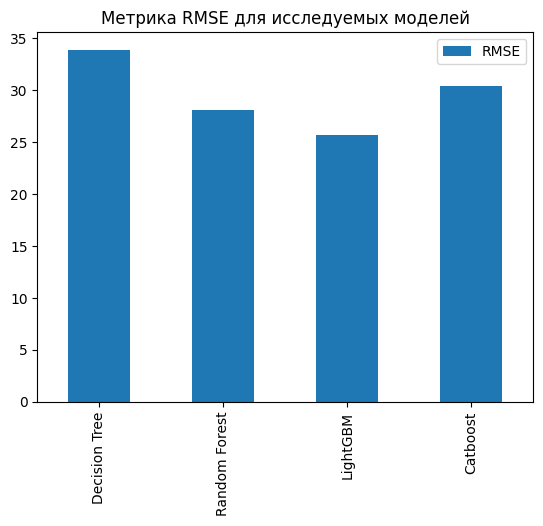

In [51]:
df.plot(kind='bar', title='Метрика RMSE для исследуемых моделей');

Меньшая метрика соответствует модели LightGBM с гиперпараметрами: ({'leaves': 31, 'n_estimators': 100}.

### Промежуточные выводы

В ходе 3 этапа проекта:
- созданы календарные признаки, признаки - "отстающие значения" и признак - скользящее среднее;
- данные разделены на таргет и нецелевые признаки, а затем полученные массивы разделены на обучающие и тестовые выборки в соотношении 9:1;
- проведено масштабирование нецелевых признаков;
- для исследования выбраны 4 модели: DesicionTree, RandomForest, LightGBM, CatBoost;
- подбор гиперпаарметров осуществлялся оптимизатором optuna в сочетании с кросс-валидацией с параметром CV=5;
- лучшая модель с наименьшей метрикой RMSE = 22.51: LightGBM с гиперпараметрами: ({'leaves': 31, 'n_estimators': 100}.

## Тестирование

### Тестовый расчет метрики RMSE на лучшей модели

In [52]:
model = lgbm.LGBMRegressor(objective="rmse", n_estimators=100, metric='rmse', num_leaves=31)
model.fit(features_train_scaled, target_train)
predicted_test = model.predict(features_test_scaled)
mean_squared_error(target_test, predicted_test)**0.5

42.199375857708475

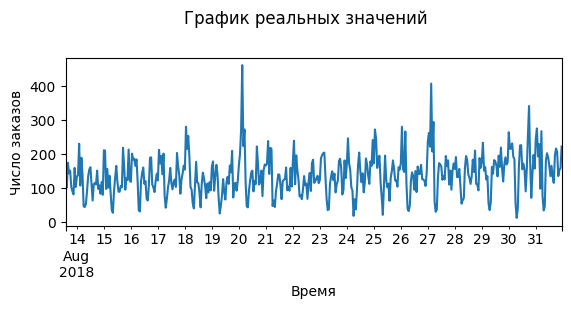

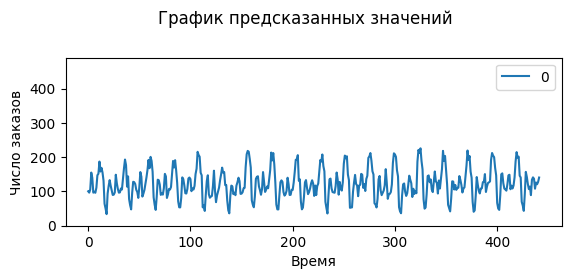

In [53]:
target_test.plot(
    title='График реальных значений', ylabel='Число заказов', xlabel='Время', subplots=True, layout=(2, 1));
pd.DataFrame(predicted_test).plot(
    title='График предсказанных значений', ylabel='Число заказов', xlabel='Время', ylim=[0, 490], \
    subplots=True, layout=(2, 1));

### Проверка качества работы модели

Для проверки адекватности работы модели рассчитаем метрику с помощью прогноза без обучения с учителем (методом заполнения предыдущим значением):

In [54]:
pred_previous = target_test.shift()
pred_previous = pred_previous.fillna(target_train[len(target_train)-1])
print("RMSE:", mean_squared_error(target_test, pred_previous)**0.5)

RMSE: 58.864269828508355


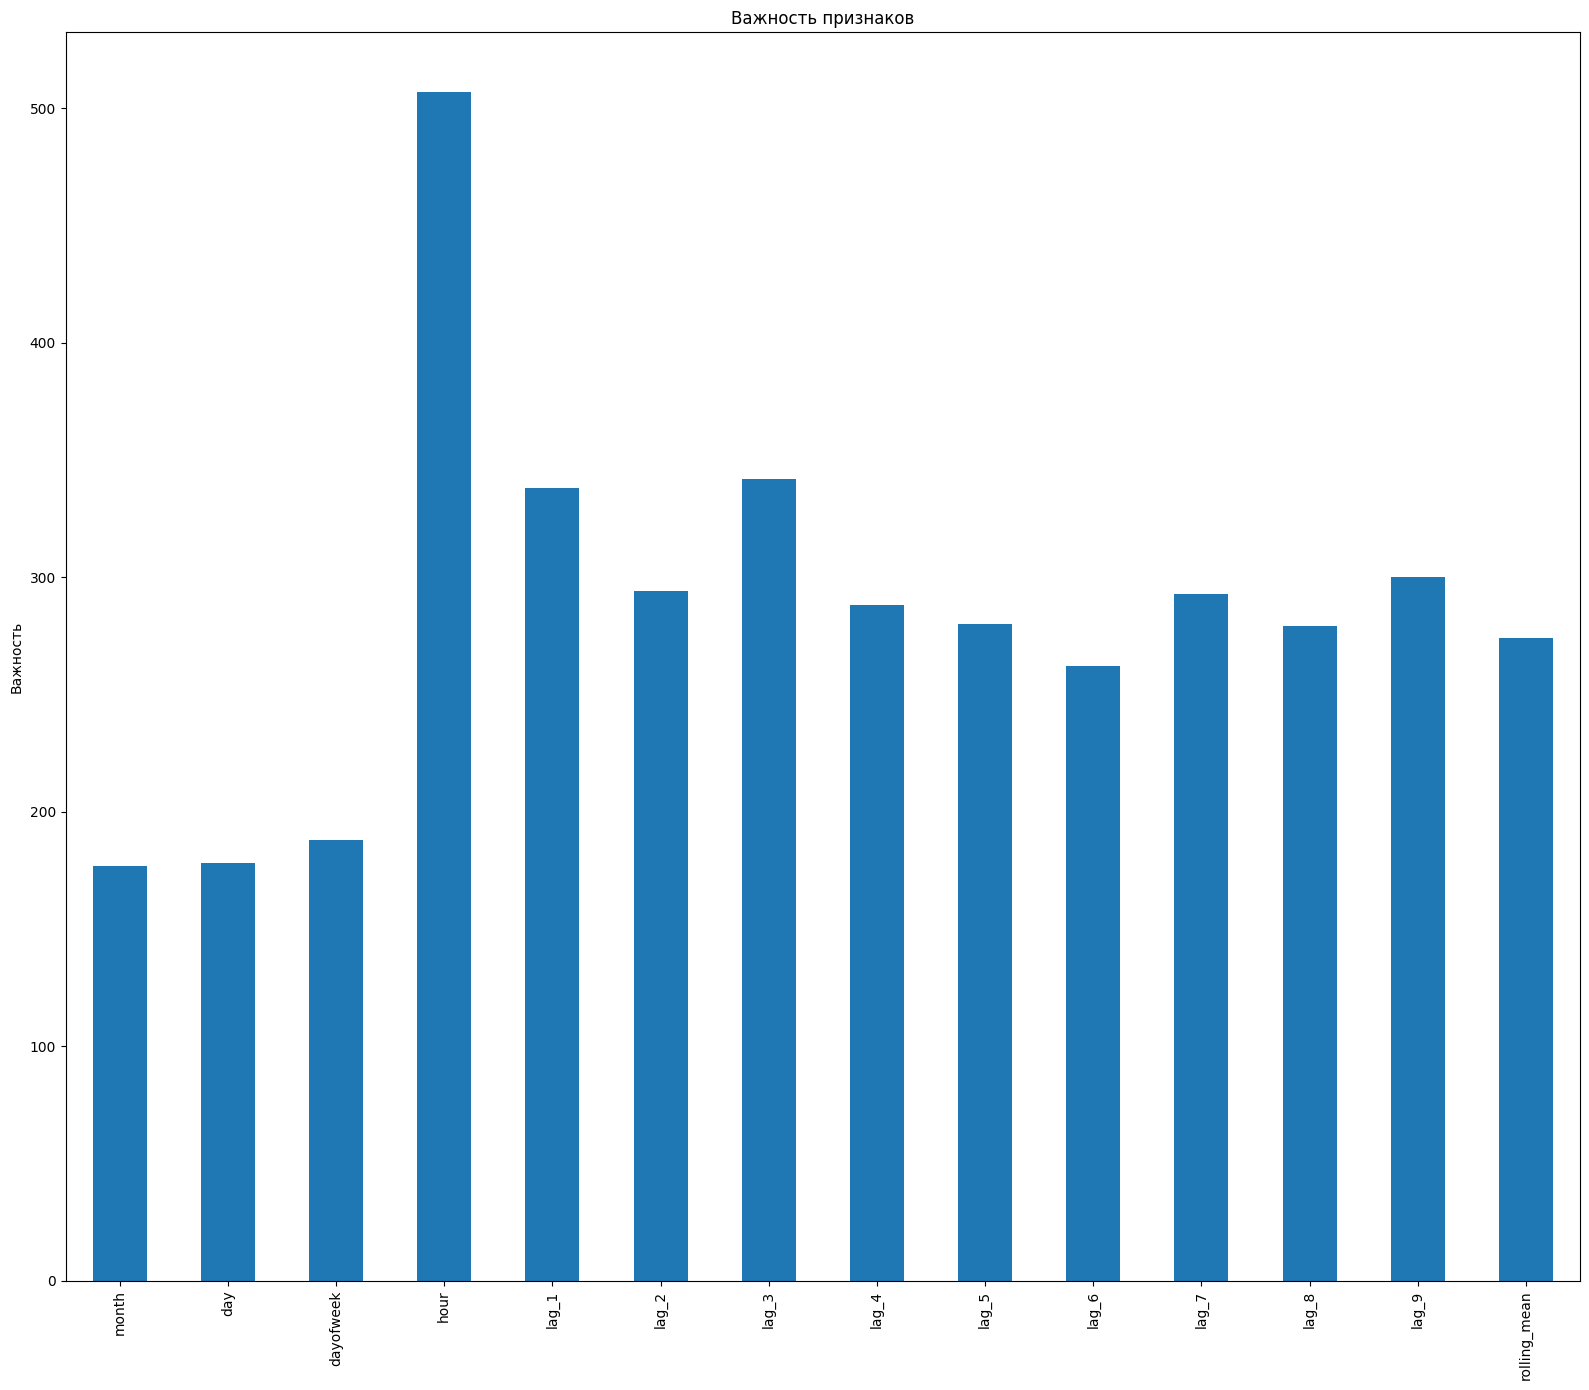

In [55]:
LGBM_feat_imp = pd.Series(model.feature_importances_,
                         features_train_scaled.columns)

fig, ax = plt.subplots(figsize=(16,14))
LGBM_feat_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

Самый важный признак - час.

### Промежуточные выводы

В ходе тестирования:
- сделан тестовый расчет метрики RMSE для выбранной модели: RMSE = 42, что удовлетворяет ограничениям по условию;
- проверка качества прогноза осуществлялась путем сравнения полученной метрики с метрикой, соответствующей предсказанию путем заполнения предыдущим значением (58 против 42, адекватность модели подтвердилась).

## Общие выводы

**Целью** выполнения проекта являлось построение модели прогнозирования количества заказов такси в аэропортах на следующий час для компании «Чётенькое такси». Ограничения: метрика RMSE <= 48.

**На этапе подготовки данных:**
загружен исходный датафрейм с 2 признаками и 26496 объектами; дубликаты и пропуски в датасете не обнаружены;
аномалий не выявлено: максимальные и минимальные значения адекватны; индекс датасета заменен значениями признака datetime, который представлен в хронологическом порядке с шагом в 10 минут; для дальнейшего прогноза на один час вперед проведено ресемплирование ряда с периодом один час.

**В ходе анализа временного ряда установлено:**
скользящее среднее и скольщее отклонение изменяются со временем, ряд можно условно назвать стационарным; присутствует тренд на возрастание числа машин в летний период, особенно с середины июля по август, что логично, поскольку это соответствует пиковому периоду отпусков; установлена сезонность по периоду, равному суткам (24 ч); использование разности временного ряда практически не сказалась на его стационарности: средние значения скользящего среднего и скольщего отклонения до разности 84.27608316260718 и 35.32905271862886, после разности - 84.25036042188331 и 35.322090028463194 соответственно.

**В ходе 3 этапа проекта:**
созданы календарные признаки, признаки - "отстающие значения" и признак - скользящее среднее; данные разделены на таргет и нецелевые признаки, а затем полученные массивы разделены на обучающие и тестовые выборки в соотношении 9:1; проведено масштабирование нецелевых признаков; для исследования выбраны 4 модели: DesicionTree, RandomForest, LightGBM, CatBoost; подбор гиперпаарметров осуществлялся оптимизатором optuna в сочетании с кросс-валидацией с параметром CV=5; лучшая модель с наименьшей метрикой RMSE = 22.51: LightGBM с гиперпараметрами: ({'leaves': 31, 'n_estimators': 100}. Также неплохие результаты показала модель RandomForest.

**На финальном этапе:**
сделан тестовый расчет метрики RMSE для выбранной модели: RMSE = 42, что удовлетворяет ограничениям по условию;
проверка качества прогноза осуществлялась путем сравнения полученной метрики с метрикой, соответствующей предсказанию путем заполнения предыдущим значением (58 против 42, адекватность модели подтвердилась).

**Таким образом,** цель проекта достигнута: предложена модель для прогнозирования количества заказов такси в аэропортах на следующий час. Это модель LightGBM с гиперпараметрами: ({'leaves': 31, 'n_estimators': 100} с метрикой RMSE = 42, удовлетворяющей требованию RMSE <= 48.

## Выводы для начальства

Для предсказания количества заказов такси в аэропортах с горизонтом прогнозирования 1 час предлагается использовать модель LightGBM с гиперпараметрами: ({'leaves': 31, 'n_estimators': 100} с метрикой RMSE = 42.